In [29]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

import pmdarima as pm
from functions_anton.functions_models import plot_forecast, find_dominant_stable_hours

In [104]:
df_train = pd.read_parquet('parquet_4_testing/train_07.parquet')
df_test = pd.read_parquet('parquet_4_testing/test_07.parquet')

In [105]:
forecast_days = 7 # how many days should be forecasted
train_days = 50 # how many days will be used to train on
sampling_rate = 60 #in minutes, very important parameter. For 5 minutes very slow, and does not add much of acc

train_start = pd.to_datetime(df_train['date'].iloc[-1]) - pd.Timedelta(days = train_days)
train_end = pd.to_datetime(df_train['date'].iloc[-1])
# The forecast starts immediately after the training data ends
forecast_start_date = train_end + pd.Timedelta(minutes=sampling_rate)
# The forecast extends for 'forecast_days' from its start
forecast_end_date = forecast_start_date + pd.Timedelta(days=forecast_days) - pd.Timedelta(minutes=sampling_rate)

In [106]:
df_sarima = df_train[(df_train['date'] >= train_start) & (df_train['date'] <= train_end) ]

#can be comment out in case no regressor: is_open needed

df_sarima['hour'] = df_sarima['date'].dt.hour
df_sarima['dayofweek'] = df_sarima['date'].dt.dayofweek

plateau_hours_by_weekday = find_dominant_stable_hours(df_sarima)
# --- Create the new binary column 'is_open' efficiently ---
df_sarima['is_open'] = 1 # Default to 1 (open) for all rows

conditions = []
choices = []
#find_dominant_stable_hours
for day_of_week_idx, (plateau_start_h, plateau_end_h) in plateau_hours_by_weekday.items():
    # Only apply a 'closed' mask if a plateau was actually detected for this day
    if plateau_start_h is not None and plateau_end_h is not None:
        mask_day = (df_sarima['dayofweek'] == day_of_week_idx)
        
        if plateau_start_h < plateau_end_h: 
            mask_hours_in_plateau = (df_sarima['hour'] >= plateau_start_h) & (df_sarima['hour'] < plateau_end_h)
        else: # Plateau wraps around midnight
            mask_hours_in_plateau = (df_sarima['hour'] >= plateau_start_h) | (df_sarima['hour'] < plateau_end_h)
        
        conditions.append(mask_day & mask_hours_in_plateau)
        choices.append(0) # Assign 0 (closed) for these periods

# Apply all conditions using np.select. Rows not covered by conditions will remain '1' (open).
df_sarima['is_open'] = np.select(conditions, choices, default=1) 

df_sarima = df_sarima.drop(columns=['hour', 'dayofweek']) 

In [107]:
# block required to resample the data to the desired frequency
#speeds up SARIMA(X) enormously
#df_sarima = df_train[(df_train['date'] >= train_start) & (df_train['date'] <= train_end) ]
df_sarima.set_index('date', inplace = True)
df_sarima.sort_index(inplace = True)
df_sarima = df_sarima.asfreq(f'{sampling_rate}T')
df_sarima = df_sarima.asfreq(pd.infer_freq(df_sarima.index)) # the infer_freq function will automatically detect the frequency of the time series data

In [108]:
# after analyzing the ACF and PACF Plots we found out how to set our parameters for the SARIMA model
s = int(1440/sampling_rate) # seasonality of the SarimA

order = (1, 0, 0) # p=1, d=1, q=1           # should be set to 0, otherwise downhill trend
seasonal_order = (2, 1, 1, s) # P=0, D=1, Q=1

print(f"Fitting SARIMA model with order={order} and seasonal_order={seasonal_order}...")
sarima_model = SARIMAX(endog = df_sarima['e5'],
                       exdog = df_sarima['is_open'],
                        order=order,
                        seasonal_order=seasonal_order,
                        trend= None, #trend='c', trend='t'
                        enforce_stationarity=False, # Often keep False for initial fitting
                        enforce_invertibility=False, # Often keep False for initial fitting
                        disp=True) # displays the progress of the fitting

sarima_model_fit = sarima_model.fit(disp=False)
#print(sarima_model_fit.summary())


Fitting SARIMA model with order=(1, 0, 0) and seasonal_order=(2, 1, 1, 24)...


In [109]:
forecast = sarima_model_fit.predict(start = train_start, end = forecast_end_date)
#use get prediction to add the future regressor values
forecast = forecast.to_frame(name="e5")
forecast = forecast.reset_index().rename(columns={'index': 'date'})

1-Day MAE in cent: 0.7692
1-Day RMSE in cent: 1.1230
3-Day MAE in cent: 0.9147
3-Day RMSE in cent: 1.4282
7-Day MAE in cent: 0.9388
7-Day RMSE in cent: 1.3818


(19886.0, 19896.0)

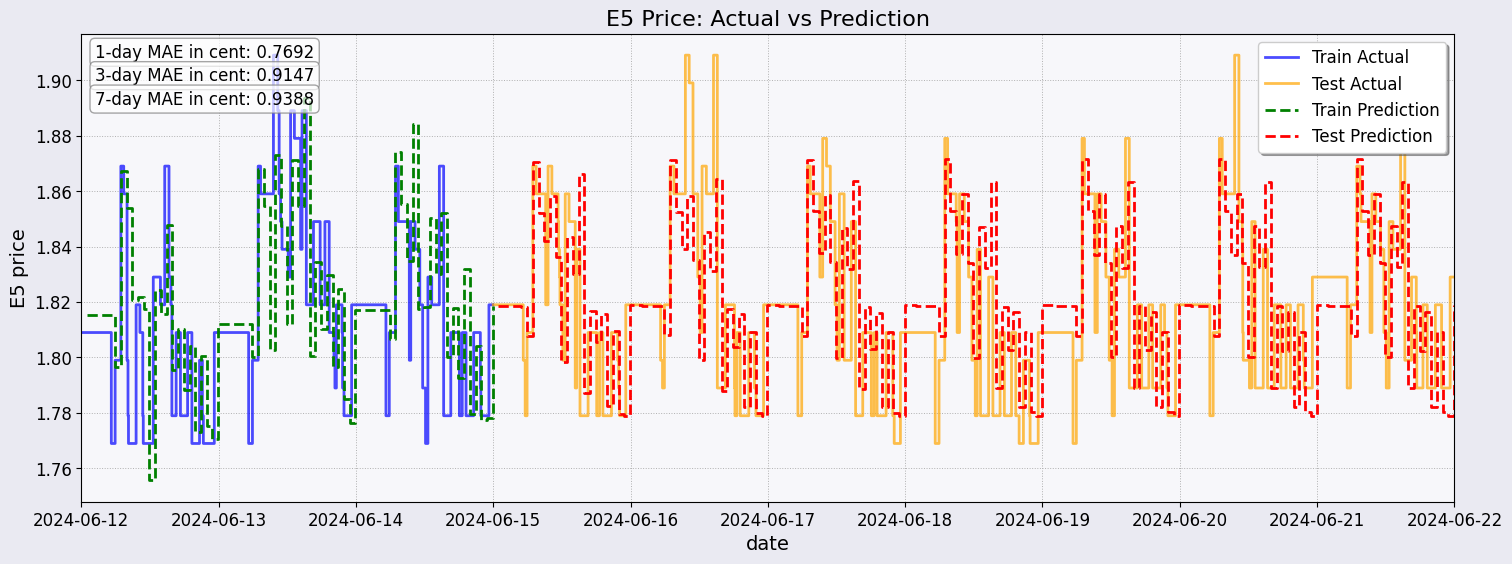

In [110]:
train_plot_start = pd.to_datetime(df_train['date'].iloc[-1]) - pd.Timedelta(days = 2)
train_plot_end = pd.to_datetime(df_train['date'].iloc[-1]) + pd.Timedelta(days = 1)

train_dates_plot = (train_plot_start.strftime('%Y-%m-%d'), train_plot_end.strftime('%Y-%m-%d'))
test_dates_plot = (forecast_start_date.strftime('%Y-%m-%d'), pd.to_datetime(forecast_end_date.strftime('%Y-%m-%d'))+ pd.Timedelta(days = 1))

plot_forecast(df_train, df_test, None, forecast, forecast, train_dates_plot, test_dates_plot)
plt.xlim(pd.to_datetime(train_dates_plot[0]),pd.to_datetime(test_dates_plot[1]))